# 패션 MINST 모델 & Matricls

- [1] 모듈로딩 및  데이터준비
- [2] 데이터 확인
- [3] 데이터 전처리 => 타겟/피쳐
- [4] 데이터 전용 데이터셋 클래스 설계 & 확인
- [5] 모델 클래스 설계 & 확인
- [6] 학습 준비
- [7] 학습
- [8] 결과확인

In [34]:
# 모듈 로딩

import torch 
import pandas as pd
import numpy as np

import torch.nn as nn 			# Tensor 및 기본 함수들 관련 모듈들
import torch.nn.functional as F # 인공신경망 관련 함수들
import torch.optim as optim 	# 최적화 모듈

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from torchmetrics.classification import * # 성능지표

In [35]:

train_DF = pd.read_csv('../Data/fashion-mnist_train.csv')
test_DF = pd.read_csv('../Data/fashion-mnist_test.csv')



In [36]:
print(train_DF.shape,test_DF.shape)

(60000, 785) (10000, 785)


In [37]:
train_DF.info()
train_DF.label.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [38]:
train_x = train_DF.loc[:,'pixel1':]
train_y =train_DF['label'] 

test_x = test_DF.loc[:,'pixel1':]
test_y =test_DF['label'] 

In [39]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [40]:
train_DF.iloc[:,0]

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

In [41]:
target = train_DF.iloc[:,0]
label = np.array(target)
label

array([2, 9, 6, ..., 8, 8, 7])

In [42]:
class my_Dataset(Dataset):
    def __init__(self, DataFrame):
        self.feature = DataFrame.iloc[:, 1:].values.astype('float32')
        self.target = DataFrame.iloc[:, 0].values.astype('int64') 

        # 정규화
        self.feature = self.feature / 255.
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.feature[idx], dtype=torch.float32).view(1, 28, 28)  # (1, 28, 28) 형태로 변환
        label = torch.tensor(self.target[idx], dtype=torch.long)  # target은 LongTensor로 변환
        
        return image, label

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
# 데이터셋 생성
train_dataset = my_Dataset(train_DF)
test_dataset = my_Dataset(test_DF)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [45]:

for label, img in train_loader:
	print(label)
	print(img)
	break



tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

# 모델설계

In [46]:
# ===============================================================
# 다중분류용 모델
# 클레스 이름 : My_Model
# 부모클래스 : nn.Module
# 모델층 구분 :  입력신호/ 		출력호수/퍼셉트론수			활성화함수
# - 입력층	  :  784				512						ReLu
# - 은닉층	  :  512				128						ReLu
# - 은닉층	  :  128				64						ReLu
# - 은닉층	  :   64				32						ReLu
# - 출력층	  :   32				10						-


class My_Model(nn.Module):
    def __init__(self):
        super(My_Model, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # 입력층
        self.fc2 = nn.Linear(512, 128)  # 은닉층 1
        self.fc3 = nn.Linear(128, 64)   # 은닉층 2
        self.fc4 = nn.Linear(64, 32)    # 은닉층 3
        self.fc5 = nn.Linear(32, 10)    # 출력층

    def forward(self, x):
        x = x.view(-1, 784)   # (Batch, 28*28)로 변환
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)  
        return x

# 모델 생성
model = My_Model()
	


In [47]:
import torch.optim as optim
from torchmetrics.classification import Accuracy

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 성능 지표 (정확도)
accuracy = Accuracy(task="multiclass", num_classes=10)

# 학습 루프
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 784)  # 1D로 펼치기
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += accuracy(outputs, labels)
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/len(train_loader):.4f}")


Epoch 1, Loss: 0.5909, Accuracy: 0.7845
Epoch 2, Loss: 0.3931, Accuracy: 0.8574
Epoch 3, Loss: 0.3502, Accuracy: 0.8730
Epoch 4, Loss: 0.3204, Accuracy: 0.8834
Epoch 5, Loss: 0.3027, Accuracy: 0.8895
Epoch 6, Loss: 0.2863, Accuracy: 0.8939
Epoch 7, Loss: 0.2730, Accuracy: 0.8995
Epoch 8, Loss: 0.2597, Accuracy: 0.9035
Epoch 9, Loss: 0.2487, Accuracy: 0.9082
Epoch 10, Loss: 0.2405, Accuracy: 0.9108


In [48]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 784)  # 1D로 펼치기
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += accuracy(outputs, labels)
    
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = correct / len(train_loader)
    
    train_losses.append(avg_loss)  # 손실 저장
    train_accuracies.append(avg_accuracy)  # 정확도 저장
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

Epoch 1, Loss: 0.2308, Accuracy: 0.9135
Epoch 2, Loss: 0.2219, Accuracy: 0.9169
Epoch 3, Loss: 0.2137, Accuracy: 0.9187
Epoch 4, Loss: 0.2042, Accuracy: 0.9243
Epoch 5, Loss: 0.2008, Accuracy: 0.9241
Epoch 6, Loss: 0.1954, Accuracy: 0.9262
Epoch 7, Loss: 0.1880, Accuracy: 0.9285
Epoch 8, Loss: 0.1821, Accuracy: 0.9313
Epoch 9, Loss: 0.1755, Accuracy: 0.9337
Epoch 10, Loss: 0.1732, Accuracy: 0.9342


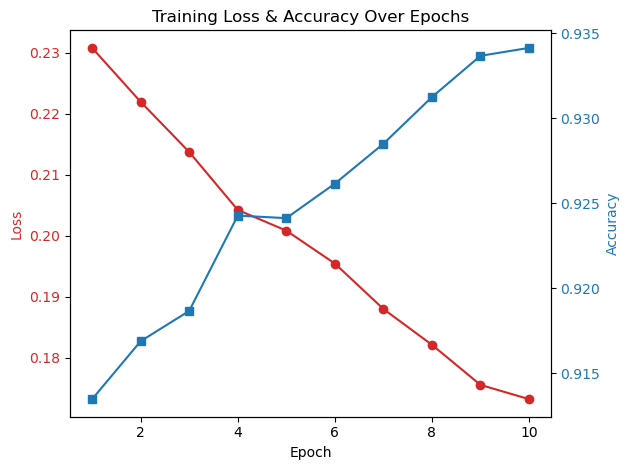

In [49]:

# 그래프 그리기
fig, ax1 = plt.subplots()

# 손실 그래프 (왼쪽 Y축)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, num_epochs + 1), train_losses, marker='o', color=color, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)

# 정확도 그래프 (오른쪽 Y축)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, num_epochs + 1), train_accuracies, marker='s', color=color, label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color)

# 제목 & 레이아웃 설정
plt.title('Training Loss & Accuracy Over Epochs')
fig.tight_layout()
plt.show()